Algorithm S&P noise SSIM is 0.96
Algortihm S&P noise PSNR is 36.55 dB
Median Filter SSIM is 0.82
Median Filter PSNR is 27.72 dB
Algorithm Gaussian noise SSIM is 0.64
Algortihm Gaussian noise PSNR is 28.18 dB
Mean Filter SSIM is 0.82
Mean Filter PSNR is 31.01 dB


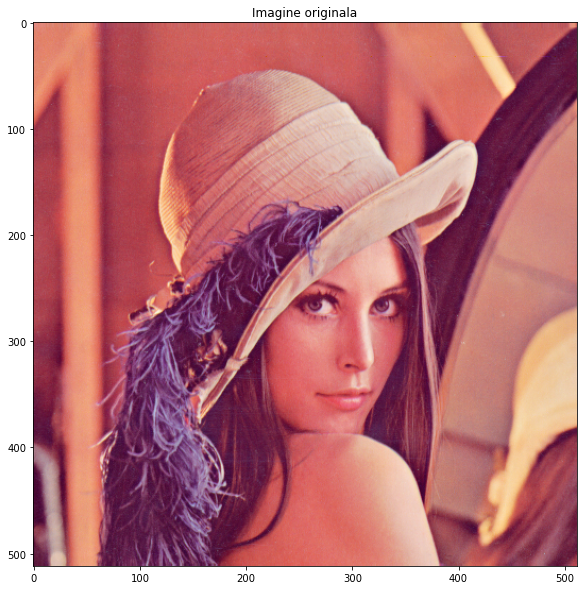

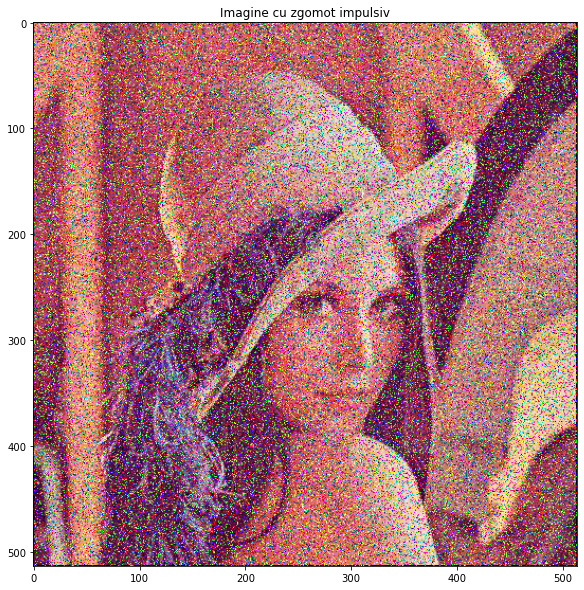

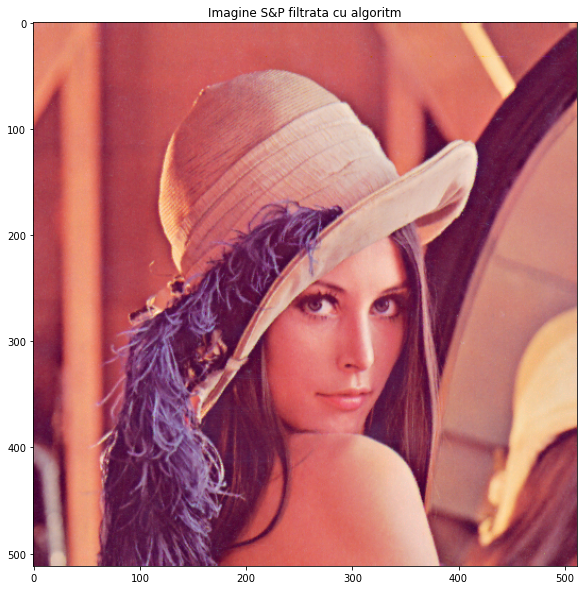

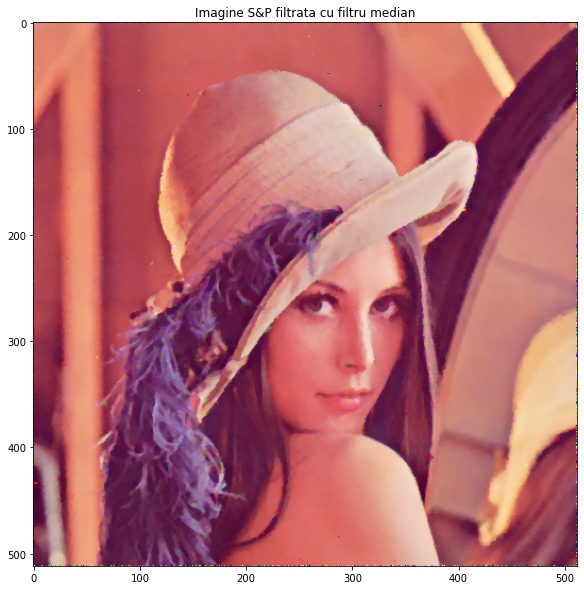

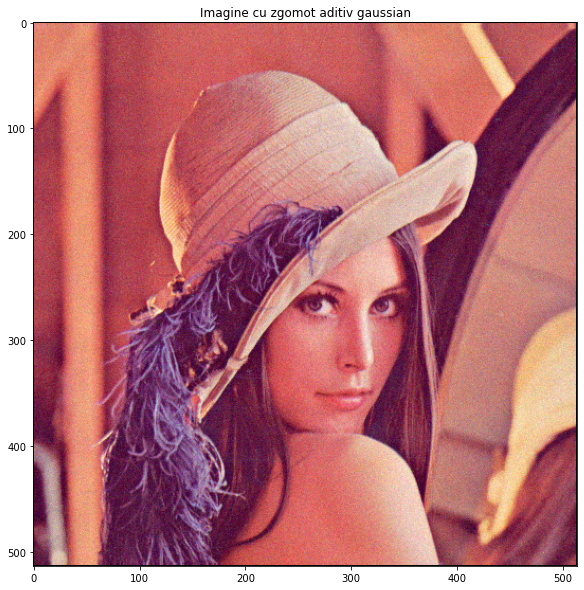

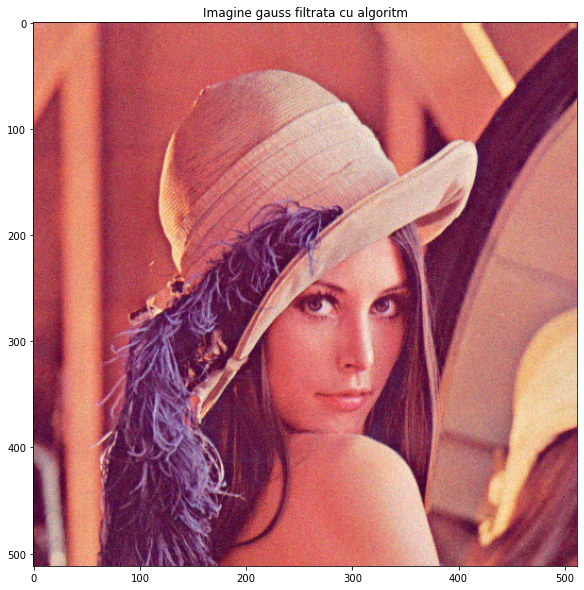

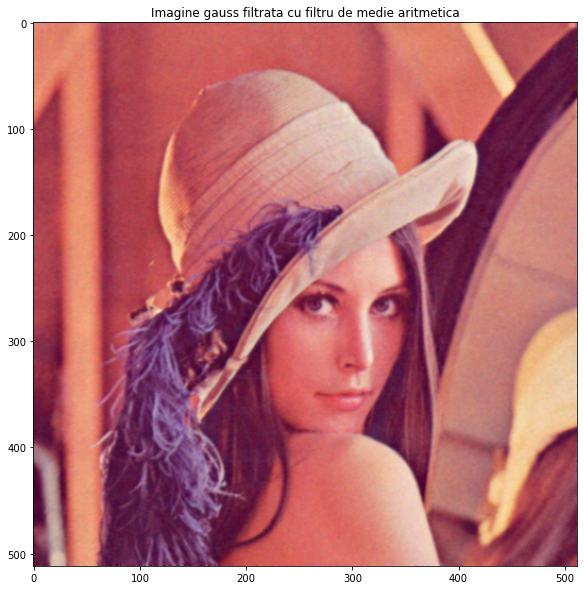

In [3]:
from skimage import io,color
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import matplotlib.pyplot as plt
import numpy as np

def add_noise_sp(img, ratio):
    img_noise = img.copy()
    l, c = img_noise.shape[0], img_noise.shape[1]
    lines = np.random.randint(0,l,[int(l*c*ratio)])
    coloumns = np.random.randint(0,c,[int(l*c*ratio)])
    up_down = np.random.randint(0,2,[int(l*c*ratio)])
    for i in range(len(lines)):
        if len(img_noise.shape) == 3:
            img_noise[lines[i], coloumns[i], np.random.randint(0,3)] = 255*up_down[i]
        else:
            img_noise[lines[i], coloumns[i]] = 255*up_down[i] 
    return img_noise

def add_noise_gauss(img, mean, dsp=10):
    img_noise = img.copy()
    if len(img_noise.shape) == 3:
        noise = np.random.normal(mean, dsp, [img_noise.shape[0],img_noise.shape[1],img_noise.shape[2]])
        img_noise = img_noise + noise
    else:
        noise = np.random.normal(mean, dsp, [img_noise.shape[0],img_noise.shape[1]])
        img_noise = img_noise + noise
        
    img_noise[img_noise>255] = 255
    img_noise[img_noise<0] = 0
    return img_noise

def filtru_medie_aritmetica(img):
    mask = np.ones([3,3])/9
    img_out = img.copy()
    if len(img_out.shape) == 3:
        l, c, ch = img_out.shape
        for i in range(2, l-2):
            for j in range(2, c-2):
                for k in range(ch):
                    img_out[i,j,k] = np.sum((img_out[i-1:i+2,j-1:j+2,k]*mask).flatten())
        return img_out[1:img_out.shape[0]-1,1:img_out.shape[1]-1,:]
    else:
        l, c = img_out.shape
        for i in range(2, l-2):
            for j in range(2, c-2):
                img_out[i,j] = np.sum((img_out[i-1:i+2,j-1:j+2]*mask).flatten())
        return img_out[1:img_out.shape[0]-1,1:img_out.shape[1]-1]

def filtru_median(img):
    img_out = img.copy()
    if len(img_out.shape) == 3:
        for i in range(2, img_out.shape[0]-2):
            for j in range(2, img_out.shape[1]-2):
                for k in range(img_out.shape[2]):
                    v = np.sort(img_out[i-1:i+2, j-1:j+2, k].flatten(), axis = None)
                    img_out[i,j,k] = v[4]
        return img_out[1:img_out.shape[0]-1,1:img_out.shape[1]-1,:]
    else:
        for i in range(2, img_out.shape[0]-2):
            for j in range(2, img_out.shape[1]-2):
                    v = np.sort(img_out[i-1:i+2, j-1:j+2].flatten(), axis = None)
                    img_out[i,j] = v[4]
        return img_out[1:img_out.shape[0]-1,1:img_out.shape[1]-1]
        
def noise_detection(img):
    l, c = img.shape[0], img.shape[1]
    S = np.zeros((l,c))
    for i in range(l):
        for j in range(c):
            if img[i,j] == 0 or img[i,j] == 255:
                S[i,j] = 0
            else:
                S[i,j] = 1        
    return S

def noise_elimination(img, S, line, col, Rmax = 39, D1 = 10, D2 = 30):
    h = np.zeros((line,col))
    L = np.zeros((line,col))
    
    for i in range(0,line):
        for j in range(0,col):
            if i == 0 or i == line-1 or j == 0 or j == col-1 or S[i,j] == 1:
                h[i,j] = img[i,j]
            else:
                ALD = [abs(h[i-1,j-1]-img[i,j]), abs(h[i-1,j]-img[i,j]), abs(h[i-1,j+1]-img[i,j]), abs(h[i,j-1]-img[i,j])] 
                M_ALD = np.max(ALD)
                
                if M_ALD <= D1:
                    L[i,j] = 0
                elif D1 < M_ALD < D2:
                    L[i,j] = (M_ALD - D1)/(D2 - D1)
                else:
                    L[i,j] = 1
                
                w = np.zeros((line,col))
                for r in range(1,Rmax+1):
                    if r == Rmax:
                        ymean = (h[i-1,j-1]+h[i-1,j]+h[i-1,j+1]+h[i,j-1])/4
                    else:
                        xi = sum(S[i-r:i+r,j-r:j+r].flatten())
                        if xi > 0:
                            for k in range(i-r,i+r+1):
                                for l in range(j-r,j+r+1):
                                    if k == i and l == j:
                                        w[k,l] = 0
                                    else:
                                        w[k,l] = 1/((k-i)**2 + (l-j)**2)
                            
                            T = S[i-r:i+r+1,j-r:j+r+1]*w[i-r:i+r+1,j-r:j+r+1]
                            T1 = T*img[i-r:i+r+1,j-r:j+r+1]
                            ymean = (sum(T1.flatten())/sum(T.flatten()))
                            break
                        else:
                            if (i-(r+1)) < 0 or (j-(r+1)) < 0 or (i+(r+1)) >= line or (j+(r+1)) >= col:
                                ymean = (h[i-1,j-1]+h[i-1,j]+h[i-1,j+1]+h[i,j-1])/4
                                break
                            else:
                                continue
                    
                h[i,j] = (1 - L[i,j])*img[i,j] + L[i,j]*ymean
                    
    return h, L

def add_borders(img):
    if len(img.shape) == 2:
        img_new = np.zeros((img.shape[0]+2,img.shape[1]+2)).astype(np.uint8)
        for i in range(img.shape[0]+2):
            for j in range(img.shape[1]+2):
                    if i == 0 or i == img.shape[0]+1 or j == 0 or j == img.shape[1]+1:
                        continue
                    else:
                        img_new[i,j] = img[i-1,j-1]
                        
    else:
        img_new = np.zeros((img.shape[0]+2,img.shape[1]+2,img.shape[2])).astype(np.uint8)
        for i in range(img.shape[0]+2):
            for j in range(img.shape[1]+2):
                for k in range(img.shape[2]):
                    if i == 0 or i == img.shape[0]+1 or j == 0 or j == img.shape[1]+1:
                        continue
                    else:
                        img_new[i,j,k] = img[i-1,j-1,k]
    return img_new

def filter_sp(img):
    if len(img.shape) == 2:
        l, c = img.shape
        S = noise_detection(img)
        h, L = noise_elimination(img, S, l, c)
        return h[1:h.shape[0]-1,1:h.shape[1]-1]
        
    else:
        l, c, ch = img.shape
        h_final = img.copy()
        for channel in range(ch):
            S = noise_detection(img[:,:,channel])
            h, L = noise_elimination(img[:,:,channel], S, l, c)
            h_final[:,:,channel] = h
        return h_final[1:h.shape[0]-1,1:h.shape[1]-1,:]

#citire si afisare imagine originala
img = io.imread('lena.png')
if len(img.shape) == 2:
    plt.figure(figsize = (10,10)), plt.imshow(img, cmap = 'gray'), plt.title('Imagine originala')
else:
    plt.figure(figsize = (10,10)), plt.imshow(img), plt.title('Imagine originala')

#adaugare frame cu pixeli de valoare 0 (negru)
img_border = add_borders(img)

#adaugare zgomot impulsiv si afisare imagine cu zgomot
img_noise = add_noise_sp(img_border, 0.90).astype(np.uint8)
if len(img_noise.shape) == 2:
    plt.figure(figsize = (10,10)), plt.imshow(img_noise, cmap = 'gray'), plt.title('Imagine cu zgomot impulsiv')
    plt.imsave('imagine_zgomot_impulsiv.png', img_noise[1:img_noise.shape[0]-1, 1:img_noise.shape[1]-1], cmap = plt.cm.gray)
else:
    plt.figure(figsize = (10,10)), plt.imshow(img_noise), plt.title('Imagine cu zgomot impulsiv')
    plt.imsave('imagine_zgomot_impulsiv.png', img_noise[1:img_noise.shape[0]-1, 1:img_noise.shape[1]-1,:])
#plt.imsave('lena_noise.png', img_noise, cmap = plt.cm.gray)

#filtrare si afisare imagine filtrata folosind algoritmul din articol si filtrul median
#si afisarea criteriilor de performante PSNR si SSIM
img_new = filter_sp(img_noise).astype(np.uint8)
img_median = filtru_median(img_noise).astype(np.uint8)
psnr_sp = psnr(img, img_new, data_range = 255)
psnr_median = psnr(img, img_median, data_range = 255)

if len(img_new.shape) == 2:
    plt.figure(figsize = (10,10)), plt.imshow(img_new, cmap = 'gray'), plt.title('Imagine S&P filtrata cu algoritm')
    plt.figure(figsize = (10,10)), plt.imshow(img_median, cmap = 'gray'), plt.title('Imagine S&P filtrata cu filtru median')
    plt.imsave('imagine_filtrata_sp_alg.png', img_new, cmap = plt.cm.gray)
    plt.imsave('imagine_filtrata_median.png', img_median, cmap = plt.cm.gray)
    ssim_sp = ssim(img, img_new, data_range = 255)
    ssim_median = ssim(img, img_median, data_range = 255)
else:
    plt.figure(figsize = (10,10)), plt.imshow(img_new), plt.title('Imagine S&P filtrata cu algoritm')
    plt.figure(figsize = (10,10)), plt.imshow(img_median), plt.title('Imagine S&P filtrata cu filtru median')
    plt.imsave('imagine_filtrata_sp_alg.png', img_new)
    plt.imsave('imagine_filtrata_median.png', img_median)
    ssim_sp = ssim(img, img_new, data_range = 255, multichannel = True)
    ssim_median = ssim(img, img_median, data_range = 255, multichannel = True)

print('Algorithm S&P noise SSIM is %.2f' %ssim_sp)
print('Algortihm S&P noise PSNR is %.2f dB' %psnr_sp)
print('Median Filter SSIM is %.2f' %ssim_median)
print('Median Filter PSNR is %.2f dB' %psnr_median)


#adaugare zgomot gaussian si afisare imagine cu zgomot
img_border_g = add_borders(img)
img_noise_g = add_noise_gauss(img_border_g, 0).astype(np.uint8)
if len(img_noise_g.shape) == 2:
    plt.figure(figsize = (10,10)), plt.imshow(img_noise_g, cmap = 'gray'), plt.title('Imagine cu zgomot aditiv gaussian')
    plt.imsave('imagine_zgomot_gaussian.png', img_noise_g[1:img_noise_g.shape[0]-1, 1:img_noise_g.shape[1]-1], cmap = plt.cm.gray)
else:
    plt.figure(figsize = (10,10)), plt.imshow(img_noise_g), plt.title('Imagine cu zgomot aditiv gaussian')
    plt.imsave('imagine_zgomot_gaussian.png', img_noise_g[1:img_noise_g.shape[0]-1, 1:img_noise_g.shape[1]-1])
    
#filtrare si afisare imagine filtrata folosind algoritmul din articol si filtrul de medie aritmetica
#si afisarea criteriilor de performante PSNR si SSIM    
img_new_g = filter_sp(img_noise_g).astype(np.uint8)
img_new_mean = filtru_medie_aritmetica(img_noise_g).astype(np.uint8)
psnr_g = psnr(img, img_new_g, data_range = 255)
psnr_mean = psnr(img, img_new_mean, data_range = 255)

if len(img_new_g.shape) == 2:
    plt.figure(figsize = (10,10)), plt.imshow(img_new_g, cmap = 'gray'), plt.title('Imagine gauss filtrata cu algoritm')
    plt.figure(figsize = (10,10)), plt.imshow(img_new_mean, cmap = 'gray'), plt.title('Imagine gauss filtrata cu filtru de medie aritmetica')
    plt.imsave('imagine_filtrata_gauss_alg.png', img_new_g, cmap = plt.cm.gray)
    plt.imsave('imagine_filtrata_mean.png', img_new_mean, cmap = plt.cm.gray)
    ssim_g = ssim(img, img_new_g, data_range = 255)
    ssim_mean = ssim(img, img_new_mean, data_range = 255)
else:
    plt.figure(figsize = (10,10)), plt.imshow(img_new_g), plt.title('Imagine gauss filtrata cu algoritm')
    plt.figure(figsize = (10,10)), plt.imshow(img_new_mean), plt.title('Imagine gauss filtrata cu filtru de medie aritmetica')
    plt.imsave('imagine_filtrata_gauss_alg.png', img_new_g)
    plt.imsave('imagine_filtrata_mean.png', img_new_mean)
    ssim_g = ssim(img, img_new_g, data_range = 255, multichannel = True)
    ssim_mean = ssim(img, img_new_mean, data_range = 255, multichannel = True)
    
print('Algorithm Gaussian noise SSIM is %.2f' %ssim_g)
print('Algortihm Gaussian noise PSNR is %.2f dB' %psnr_g)   
print('Mean Filter SSIM is %.2f' %ssim_mean)
print('Mean Filter PSNR is %.2f dB' %psnr_mean)  
